In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      kernel_initializer='he_uniform', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      kernel_initializer='he_uniform')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, 
                          padding='same', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))    
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, 
                          padding='same', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())        
        model.add(Activation('relu'))    
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4586 - acc: 0.3209
Epoch 00001: val_loss improved from inf to 1.63576, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_3_conv_checkpoint/001-1.6358.hdf5
36805/36805 [==============================] - 143s 4ms/sample - loss: 2.4586 - acc: 0.3208 - val_loss: 1.6358 - val_acc: 0.5134
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6454 - acc: 0.5098
Epoch 00002: val_loss improved from 1.63576 to 1.57037, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_3_conv_checkpoint/002-1.5704.hdf5
36805/36805 [==============================] - 135s 4ms/sample - loss: 1.6456 - acc: 0.5098 - val_loss: 1.5704 - val_acc: 0.5213
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3123 - acc: 0.6035
Epoch 00003: val_loss improved 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1243 - acc: 0.9616
Epoch 00028: val_loss did not improve from 1.36965
36805/36805 [==============================] - 134s 4ms/sample - loss: 0.1249 - acc: 0.9615 - val_loss: 1.9967 - val_acc: 0.6452
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1277 - acc: 0.9608
Epoch 00029: val_loss did not improve from 1.36965
36805/36805 [==============================] - 133s 4ms/sample - loss: 0.1277 - acc: 0.9608 - val_loss: 1.7833 - val_acc: 0.6513
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1063 - acc: 0.9671
Epoch 00030: val_loss did not improve from 1.36965
36805/36805 [==============================] - 133s 4ms/sample - loss: 0.1063 - acc: 0.9672 - val_loss: 1.8625 - val_acc: 0.6529
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1073 - acc: 0.9667
Epoch 00031: val_loss did not improve from 1.36965
36805/36805 [========

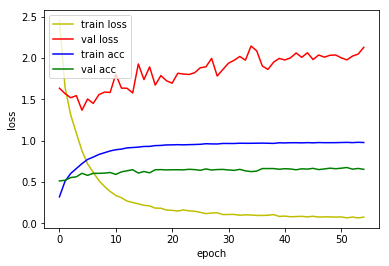

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.4715 - acc: 0.5755
Loss: 1.4714836027268186 Accuracy: 0.5754933

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3482 - acc: 0.3180
Epoch 00001: val_loss improved from inf to 1.52980, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_4_conv_checkpoint/001-1.5298.hdf5
36805/36805 [==============================] - 149s 4ms/sample - loss: 2.3480 - acc: 0.3181 - val_loss: 1.5298 - val_acc: 0.5285
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5818 - acc: 0.5154
Epoch 00002: val_loss improved from 1.52980 to 1.24527, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_4_conv_checkpoint/002-1.2453.hdf5
36805/36805 [==============================] - 142s 4ms/sample - loss: 1.5818 - acc: 0.5154 - val_loss: 1.2453 - val_acc: 0.6122
Epoch 3/500
36800/36805 [================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2258 - acc: 0.9252
Epoch 00026: val_loss did not improve from 0.85722
36805/36805 [==============================] - 142s 4ms/sample - loss: 0.2259 - acc: 0.9252 - val_loss: 0.9900 - val_acc: 0.7587
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2273 - acc: 0.9252
Epoch 00027: val_loss did not improve from 0.85722
36805/36805 [==============================] - 142s 4ms/sample - loss: 0.2274 - acc: 0.9252 - val_loss: 0.9381 - val_acc: 0.7692
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2172 - acc: 0.9287
Epoch 00028: val_loss did not improve from 0.85722
36805/36805 [==============================] - 142s 4ms/sample - loss: 0.2175 - acc: 0.9286 - val_loss: 1.0056 - val_acc: 0.7508
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2164 - acc: 0.9295
Epoch 00029: val_loss did not improve from 0.85722
36805/36805 [=====================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1130 - acc: 0.9643
Epoch 00056: val_loss did not improve from 0.85722
36805/36805 [==============================] - 143s 4ms/sample - loss: 0.1132 - acc: 0.9643 - val_loss: 1.0518 - val_acc: 0.7803
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1156 - acc: 0.9633
Epoch 00057: val_loss did not improve from 0.85722
36805/36805 [==============================] - 141s 4ms/sample - loss: 0.1157 - acc: 0.9632 - val_loss: 1.0759 - val_acc: 0.7778
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1096 - acc: 0.9649
Epoch 00058: val_loss did not improve from 0.85722
36805/36805 [==============================] - 142s 4ms/sample - loss: 0.1096 - acc: 0.9649 - val_loss: 1.0879 - val_acc: 0.7785
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1046 - acc: 0.9665
Epoch 00059: val_loss did not improve from 0.85722
36805/36805 [========

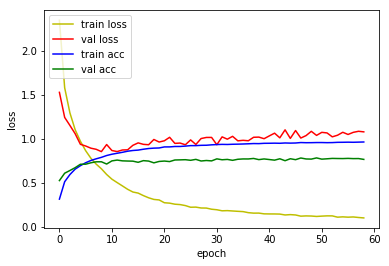

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.9891 - acc: 0.7080
Loss: 0.9890744084757312 Accuracy: 0.70799583

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4499 - acc: 0.2992
Epoch 00001: val_loss improved from inf to 1.40025, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_5_conv_checkpoint/001-1.4003.hdf5
36805/36805 [==============================] - 158s 4ms/sample - loss: 2.4499 - acc: 0.2992 - val_loss: 1.4003 - val_acc: 0.5761
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5073 - acc: 0.5402
Epoch 00002: val_loss improved from 1.40025 to 1.04423, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_5_conv_checkpoint/002-1.0442.hdf5
36805/36805 [==============================] - 149s 4ms/sample - loss: 1.5073 - acc: 0.5402 - val_loss: 1.0442 - val_acc: 0.6886
Epoch 3/500
36800/36805 [===============

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2759 - acc: 0.9138
Epoch 00026: val_loss did not improve from 0.62596
36805/36805 [==============================] - 149s 4ms/sample - loss: 0.2760 - acc: 0.9138 - val_loss: 0.6680 - val_acc: 0.8281
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2649 - acc: 0.9157
Epoch 00027: val_loss did not improve from 0.62596
36805/36805 [==============================] - 149s 4ms/sample - loss: 0.2649 - acc: 0.9157 - val_loss: 0.6793 - val_acc: 0.8307
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2551 - acc: 0.9177
Epoch 00028: val_loss did not improve from 0.62596
36805/36805 [==============================] - 149s 4ms/sample - loss: 0.2551 - acc: 0.9177 - val_loss: 0.6459 - val_acc: 0.8348
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2419 - acc: 0.9234
Epoch 00029: val_loss did not improve from 0.62596
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1187 - acc: 0.9613
Epoch 00056: val_loss did not improve from 0.62596
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.1187 - acc: 0.9612 - val_loss: 0.7081 - val_acc: 0.8467
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1180 - acc: 0.9630
Epoch 00057: val_loss did not improve from 0.62596
36805/36805 [==============================] - 149s 4ms/sample - loss: 0.1179 - acc: 0.9630 - val_loss: 0.6983 - val_acc: 0.8411
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1134 - acc: 0.9637
Epoch 00058: val_loss did not improve from 0.62596
36805/36805 [==============================] - 150s 4ms/sample - loss: 0.1137 - acc: 0.9637 - val_loss: 0.7152 - val_acc: 0.8498
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1148 - acc: 0.9631
Epoch 00059: val_loss did not improve from 0.62596
36805/36805 [========

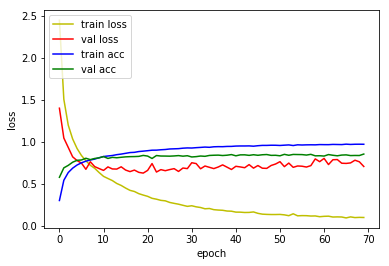

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.7134 - acc: 0.8027
Loss: 0.7134456227501604 Accuracy: 0.8026999

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4860 - acc: 0.2734
Epoch 00001: val_loss improved from inf to 1.44894, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_6_conv_checkpoint/001-1.4489.hdf5
36805/36805 [==============================] - 164s 4ms/sample - loss: 2.4859 - acc: 0.2734 - val_loss: 1.4489 - val_acc: 0.5518
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5521 - acc: 0.5104
Epoch 00002: val_loss improved from 1.44894 to 1.03016, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_6_conv_checkpoint/002-1.0302.hdf5
36805/36805 [==============================] - 152s 4ms/sample - loss: 1.5520 - acc: 0.5104 - val_loss: 1.0302 - val_acc: 0.6902
Epoch 3/500
36800/36805 [================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2825 - acc: 0.9119
Epoch 00023: val_loss did not improve from 0.36330
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.2824 - acc: 0.9119 - val_loss: 0.3977 - val_acc: 0.8966
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2602 - acc: 0.9192
Epoch 00024: val_loss did not improve from 0.36330
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.2602 - acc: 0.9192 - val_loss: 0.3700 - val_acc: 0.9068
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2527 - acc: 0.9214
Epoch 00025: val_loss did not improve from 0.36330
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.2529 - acc: 0.9214 - val_loss: 0.4057 - val_acc: 0.8963
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2512 - acc: 0.9210
Epoch 00026: val_loss did not improve from 0.36330
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1109 - acc: 0.9634
Epoch 00052: val_loss did not improve from 0.35975
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.1109 - acc: 0.9634 - val_loss: 0.3972 - val_acc: 0.9117
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0999 - acc: 0.9686
Epoch 00053: val_loss did not improve from 0.35975
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.1000 - acc: 0.9685 - val_loss: 0.3805 - val_acc: 0.9166
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1024 - acc: 0.9660
Epoch 00054: val_loss did not improve from 0.35975
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.1026 - acc: 0.9659 - val_loss: 0.4105 - val_acc: 0.9143
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0942 - acc: 0.9701
Epoch 00055: val_loss did not improve from 0.35975
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0635 - acc: 0.9800
Epoch 00081: val_loss did not improve from 0.35706
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0637 - acc: 0.9800 - val_loss: 0.4344 - val_acc: 0.9106
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0644 - acc: 0.9795
Epoch 00082: val_loss did not improve from 0.35706
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0645 - acc: 0.9794 - val_loss: 0.4254 - val_acc: 0.9138
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0722 - acc: 0.9770
Epoch 00083: val_loss did not improve from 0.35706
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0723 - acc: 0.9770 - val_loss: 0.4842 - val_acc: 0.9047
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0624 - acc: 0.9794
Epoch 00084: val_loss did not improve from 0.35706
36805/36805 [=====================

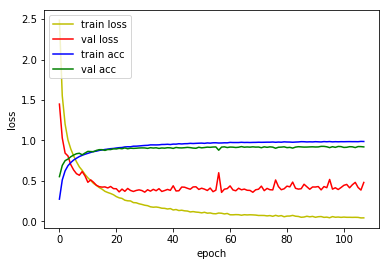

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.4141 - acc: 0.8939
Loss: 0.41413822502114445 Accuracy: 0.89387333

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7153 - acc: 0.2073
Epoch 00001: val_loss improved from inf to 1.71362, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_7_conv_checkpoint/001-1.7136.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 2.7153 - acc: 0.2073 - val_loss: 1.7136 - val_acc: 0.4871
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7875 - acc: 0.4265
Epoch 00002: val_loss improved from 1.71362 to 1.20835, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_7_conv_checkpoint/002-1.2083.hdf5
36805/36805 [==============================] - 155s 4ms/sample - loss: 1.7874 - acc: 0.4265 - val_loss: 1.2083 - val_acc: 0.6275
Epoch 3/500
36800/36805 [==============

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1788 - acc: 0.9434
Epoch 00024: val_loss improved from 0.20298 to 0.19085, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_7_conv_checkpoint/024-0.1909.hdf5
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.1789 - acc: 0.9433 - val_loss: 0.1909 - val_acc: 0.9497
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1762 - acc: 0.9447
Epoch 00025: val_loss did not improve from 0.19085
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.1764 - acc: 0.9447 - val_loss: 0.2111 - val_acc: 0.9450
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1655 - acc: 0.9477
Epoch 00026: val_loss did not improve from 0.19085
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.1656 - acc: 0.9477 - val_loss: 0.2479 - val_acc: 0.9306
Epoch 27/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.0704 - acc: 0.9783
Epoch 00052: val_loss did not improve from 0.18934
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.0704 - acc: 0.9783 - val_loss: 0.2066 - val_acc: 0.9485
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0642 - acc: 0.9790
Epoch 00053: val_loss did not improve from 0.18934
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.0642 - acc: 0.9791 - val_loss: 0.2105 - val_acc: 0.9509
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0606 - acc: 0.9811
Epoch 00054: val_loss did not improve from 0.18934
36805/36805 [==============================] - 152s 4ms/sample - loss: 0.0607 - acc: 0.9811 - val_loss: 0.1987 - val_acc: 0.9492
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0621 - acc: 0.9808
Epoch 00055: val_loss did not improve from 0.18934
36805/36805 [=====================

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0427 - acc: 0.9859
Epoch 00082: val_loss did not improve from 0.18934
36805/36805 [==============================] - 155s 4ms/sample - loss: 0.0428 - acc: 0.9858 - val_loss: 0.1952 - val_acc: 0.9548
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9899
Epoch 00083: val_loss did not improve from 0.18934
36805/36805 [==============================] - 155s 4ms/sample - loss: 0.0327 - acc: 0.9899 - val_loss: 0.2157 - val_acc: 0.9529
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9872
Epoch 00084: val_loss did not improve from 0.18934
36805/36805 [==============================] - 155s 4ms/sample - loss: 0.0402 - acc: 0.9872 - val_loss: 0.1946 - val_acc: 0.9571
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9898
Epoch 00085: val_loss did not improve from 0.18934
36805/36805 [========

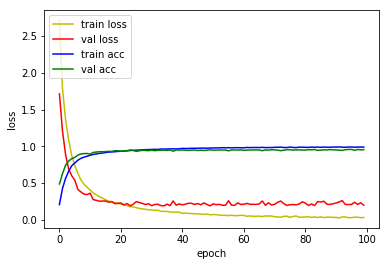

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.2123 - acc: 0.9418
Loss: 0.21225474257706853 Accuracy: 0.9418484

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8214 - acc: 0.1902
Epoch 00001: val_loss improved from inf to 1.81076, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_8_conv_checkpoint/001-1.8108.hdf5
36805/36805 [==============================] - 173s 5ms/sample - loss: 2.8213 - acc: 0.1903 - val_loss: 1.8108 - val_acc: 0.4715
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8319 - acc: 0.4310
Epoch 00002: val_loss improved from 1.81076 to 1.11627, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_8_conv_checkpoint/002-1.1163.hdf5
36805/36805 [==============================] - 156s 4ms/sample - loss: 1.8320 - acc: 0.4310 - val_loss: 1.1163 - val_acc: 0.6853
Epoch 3/500
36800/36805 [==============

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1420 - acc: 0.9541
Epoch 00023: val_loss did not improve from 0.14140
36805/36805 [==============================] - 156s 4ms/sample - loss: 0.1419 - acc: 0.9541 - val_loss: 0.1508 - val_acc: 0.9588
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1373 - acc: 0.9553
Epoch 00024: val_loss did not improve from 0.14140
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.1375 - acc: 0.9553 - val_loss: 0.1471 - val_acc: 0.9550
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1295 - acc: 0.9589
Epoch 00025: val_loss did not improve from 0.14140
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.1295 - acc: 0.9589 - val_loss: 0.1589 - val_acc: 0.9553
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1253 - acc: 0.9611
Epoch 00026: val_loss improved from 0.14140 to 0.12811, saving model to 

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0584 - acc: 0.9818
Epoch 00051: val_loss did not improve from 0.11642
36805/36805 [==============================] - 156s 4ms/sample - loss: 0.0584 - acc: 0.9818 - val_loss: 0.1250 - val_acc: 0.9639
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9853
Epoch 00052: val_loss did not improve from 0.11642
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.0465 - acc: 0.9852 - val_loss: 0.1219 - val_acc: 0.9651
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.9839
Epoch 00053: val_loss did not improve from 0.11642
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.0516 - acc: 0.9839 - val_loss: 0.1266 - val_acc: 0.9632
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9875
Epoch 00054: val_loss did not improve from 0.11642
36805/36805 [========

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9926
Epoch 00081: val_loss did not improve from 0.11642
36805/36805 [==============================] - 153s 4ms/sample - loss: 0.0249 - acc: 0.9926 - val_loss: 0.1352 - val_acc: 0.9672
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9931
Epoch 00082: val_loss did not improve from 0.11642
36805/36805 [==============================] - 155s 4ms/sample - loss: 0.0223 - acc: 0.9930 - val_loss: 0.1672 - val_acc: 0.9599
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9896
Epoch 00083: val_loss did not improve from 0.11642
36805/36805 [==============================] - 156s 4ms/sample - loss: 0.0360 - acc: 0.9895 - val_loss: 0.1475 - val_acc: 0.9625
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0304 - acc: 0.9905
Epoch 00084: val_loss did not improve from 0.11642
36805/36805 [========

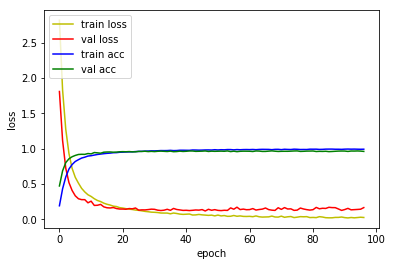

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.1671 - acc: 0.9543
Loss: 0.16711079795232675 Accuracy: 0.95430946

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5653 - acc: 0.2709
Epoch 00001: val_loss improved from inf to 1.29242, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_9_conv_checkpoint/001-1.2924.hdf5
36805/36805 [==============================] - 178s 5ms/sample - loss: 2.5651 - acc: 0.2709 - val_loss: 1.2924 - val_acc: 0.5945
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3424 - acc: 0.5838
Epoch 00002: val_loss improved from 1.29242 to 0.70729, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_9_conv_checkpoint/002-0.7073.hdf5
36805/36805 [==============================] - 158s 4ms/sample - loss: 1.3423 - acc: 0.5838 - val_loss: 0.7073 - val_acc: 0.7871
Epoch 3/500
36800/36805 [=============

36800/36805 [============================>.] - ETA: 0s - loss: 0.0895 - acc: 0.9716
Epoch 00024: val_loss did not improve from 0.12933
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0895 - acc: 0.9716 - val_loss: 0.1461 - val_acc: 0.9564
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0794 - acc: 0.9751
Epoch 00025: val_loss did not improve from 0.12933
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0794 - acc: 0.9750 - val_loss: 0.1534 - val_acc: 0.9541
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0813 - acc: 0.9744
Epoch 00026: val_loss did not improve from 0.12933
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0812 - acc: 0.9744 - val_loss: 0.1390 - val_acc: 0.9609
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0712 - acc: 0.9776
Epoch 00027: val_loss did not improve from 0.12933
36805/36805 [=====================

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9926
Epoch 00053: val_loss did not improve from 0.12843
36805/36805 [==============================] - 155s 4ms/sample - loss: 0.0253 - acc: 0.9926 - val_loss: 0.1429 - val_acc: 0.9641
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9917
Epoch 00054: val_loss did not improve from 0.12843
36805/36805 [==============================] - 155s 4ms/sample - loss: 0.0256 - acc: 0.9917 - val_loss: 0.1552 - val_acc: 0.9620
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9917
Epoch 00055: val_loss did not improve from 0.12843
36805/36805 [==============================] - 156s 4ms/sample - loss: 0.0265 - acc: 0.9917 - val_loss: 0.1701 - val_acc: 0.9616
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9921
Epoch 00056: val_loss did not improve from 0.12843
36805/36805 [========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0169 - acc: 0.9950
Epoch 00083: val_loss did not improve from 0.12843
36805/36805 [==============================] - 155s 4ms/sample - loss: 0.0169 - acc: 0.9949 - val_loss: 0.1603 - val_acc: 0.9655
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9957
Epoch 00084: val_loss did not improve from 0.12843
36805/36805 [==============================] - 155s 4ms/sample - loss: 0.0141 - acc: 0.9957 - val_loss: 0.1519 - val_acc: 0.9646
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0128 - acc: 0.9962
Epoch 00085: val_loss did not improve from 0.12843
36805/36805 [==============================] - 155s 4ms/sample - loss: 0.0129 - acc: 0.9962 - val_loss: 0.1690 - val_acc: 0.9634

1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_9_conv Model


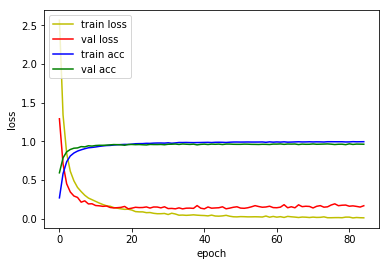

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.1814 - acc: 0.9506
Loss: 0.18136075342215233 Accuracy: 0.9505711



In [10]:
base = '1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN'

for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
        
    model = multi_gpu_model(model, gpus=2)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_90_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           1883216     lambda[0][0]                     
                                                     

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.2123 - acc: 0.9418
Loss: 0.21225474257706853 Accuracy: 0.9418484

1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_140_input (InputLayer)   (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_140_input[0][0]           
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_140_input[0][0]           
__________________________________________________________________________________________________
sequential_14 (Se

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_90_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           1883216     lambda[0][0]                     
                                                     

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.2379 - acc: 0.9423
Loss: 0.23786049854350766 Accuracy: 0.9422638

1D_CNN_custom_conv_3_VGG_he-uniform_DO_BN_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_140_input (InputLayer)   (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_140_input[0][0]           
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_140_input[0][0]           
__________________________________________________________________________________________________
sequential_14 (Se